### SciBmad: Polymorphism and High Order Autodifferentiation

This simple example shows how, using SciBmad's fully polymorphic and differentiable lattice definition and tracking routines, one can compute high order derivatives of quantities of interest.

Let's construct a simple FODO cell, and compute the quadrupole strengths needed to set the phase advance of the cell to $90\degree$.

In this example we will use the `Beamlines.jl`, `GTPSA.jl`, and `NonlinearNormalForm.jl` packages within the SciBmad ecosystem

In [63]:
using Revise, Plots, Beamlines, GTPSA, NonlinearNormalForm

Define a function to create a FODO cell with `Linear` tracking selected:

In [64]:
function make_fodo(K1, L_quad, L_drift)
  qf = Quadrupole(K1=K1, L=L_quad, tracking_method=Linear())
  d1 = Drift(L=L_drift, tracking_method=Linear())
  qd = Quadrupole(K1=-qf.K1, L=L_quad, tracking_method=Linear())
  d2 = Drift(L=L_drift, tracking_method=Linear())
  return [qf, d1, qd, d2]
end

make_fodo (generic function with 4 methods)

We can make a FODO `Beamline` using the following list comprehension now:

In [65]:
N_fodo = 1
K1 = 0.36
L_quad = 0.5
L_drift = 6.0

bl = Beamline([ele for i in 1:N_fodo for ele in make_fodo(K1, L_quad, L_drift)]; Brho_ref=60.0)


Beamline(LineElement[LineElement(Dict{Type{<:AbstractParams}, AbstractParams}(UniversalParams => UniversalParams(Linear(), 0.5, "Quadrupole", ""), BeamlineParams => BeamlineParams(Beamline(#= circular reference @-5 =#), 1), BMultipoleParams => BMultipoleParams{Float64}(Dict{Int64, BMultipole{Float64}}(2 => BMultipole{Float64}(0.36, 0.0, 2, true, false))))), LineElement(Dict{Type{<:AbstractParams}, AbstractParams}(UniversalParams => UniversalParams(Linear(), 6.0, "Drift", ""), BeamlineParams => BeamlineParams(Beamline(#= circular reference @-5 =#), 2))), LineElement(Dict{Type{<:AbstractParams}, AbstractParams}(UniversalParams => UniversalParams(Linear(), 0.5, "Quadrupole", ""), BeamlineParams => BeamlineParams(Beamline(#= circular reference @-5 =#), 3), BMultipoleParams => BMultipoleParams{Float64}(Dict{Int64, BMultipole{Float64}}(2 => BMultipole{Float64}(-0.36, 0.0, 2, true, false))))), LineElement(Dict{Type{<:AbstractParams}, AbstractParams}(UniversalParams => UniversalParams(Linear()

Now, we can let the phase space coordinates and quadrupole strengths be GTPSA variables, so that we can obtain both the linear transport matrix $M$ of particles propagating through our FODO cell, as well as the dependence of each $M_{ij}$ on the quadrupole strength.

To calculate the linear phase advance in this uncoupled case, we can simple use $\textrm{acos}(\frac{1}{2}\textrm{Tr} M)$ for each oscillating plane. As such, we only need the first order derivatives of the phase space coordinates, and using GTPSA we can choose whatever order we want for the derivatives of the parameter (in this case, the change in quadrupole strength).

Let's define a GTPSA `Descriptor` for 1st order in the 4 phase space variables, and 10th order in the change in quadrupole strength. 

In [66]:
 # 10+4 is the maximum truncation order
 # This ensures we do not lose accuracy by ignoring 
 # higher order cross terms with ΔK1 
const D = Descriptor([1,1,1,1,10], 10+4)
Δx = @vars(D)[1:4]
ΔK1 = @vars(D)[5]

TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}:
 Coefficient                Order   Exponent
  1.0000000000000000e+00      1      0   0   0   0   1


Now, we can use `Beamlines.jl`'s `Controller` type to simultaneously control all focusing and defocusing quadrupoles with a single knob.

To get all of the focusing and defocusing quadrupoles, we use the standard Julia function `findall`. We then define a `Controller` with variable `x`, which sets each focusing quadrupole's `K1 = x`, and each defocusing quadrupole's `K1 = -x`. We then set the controller to be a TPSA expanded around the original `K1` from above.

In [67]:
qf_idxs = findall(t->t.class=="Quadrupole" && t.K1 > 0, bl.line)
qd_idxs = findall(t->t.class=="Quadrupole" && t.K1 < 0, bl.line)
qfs = bl.line[qf_idxs] # Contains all focusing quadrupoles
qds = bl.line[qd_idxs] # Contains all defocusing quadrupoles

# Now make controller to set all of these
cq = Controller(
  map(t->(t, :K1) => (ele; x) -> x, qfs)...,
  map(t->(t, :K1) => (ele; x) -> -x, qds)...,
  vars = (; x = 0.0)
)

# Now make TPSA
cq.x = K1 + ΔK1

TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}:
 Coefficient                Order   Exponent
  3.5999999999999999e-01      0      0   0   0   0   0
  1.0000000000000000e+00      1      0   0   0   0   1


Now let's construct our `Bunch`, as a TPSA expanded around zero. And then track!

In [68]:
bunch = Bunch(x=Δx[1], px=Δx[2], y=Δx[3], py=Δx[4])
track!(bunch, bl)

Bunch{Float64, StructArrays.StructVector{Beamlines.Coord{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}, @NamedTuple{x::Vector{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}, px::Vector{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}, y::Vector{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}, py::Vector{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}}, Int64}}(Beamlines.Species("electron", 0.51099895069, -1.602176634e-19), 60.0, Beamlines.Coord{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}[4-element Beamlines.Coord{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}:
 Index Coefficient                Order   Exponent
----------------------------------------------------------------
   1:  -1.4345415526880321e+00      1      1   0   0   0   0
   1:   1.9807339632633717e+01      1      0   1   0   0   0
   1:  -1.0273794209191596e+01      2      1   0   0   0   1
   1:   1.8313602082027330e+01      2      0   1   0   0   1
   1:  -9.74844471485959

The Bunch struct could contain many particles, but in this case we just care about our one particle. To get a simplified `Particle` struct from the `Bunch`, we can just do

In [69]:
p = Particle(bunch, 1) # Gets the first particle in the bunch
p.v # Parametric GTPSA map

4-element Beamlines.Coord{TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}}:
 Index Coefficient                Order   Exponent
----------------------------------------------------------------
   1:  -1.4345415526880321e+00      1      1   0   0   0   0
   1:   1.9807339632633717e+01      1      0   1   0   0   0
   1:  -1.0273794209191596e+01      2      1   0   0   0   1
   1:   1.8313602082027330e+01      2      0   1   0   0   1
   1:  -9.7484447148595930e+00      3      1   0   0   0   2
   1:  -1.6683451253815633e+00      3      0   1   0   0   2
   1:   1.5746295136582426e-02      4      1   0   0   0   3
   1:  -3.7867704516003742e-02      4      0   1   0   0   3
   1:   6.4732024014747397e-03      5      1   0   0   0   4
   1:   4.7084712341735743e-04      5      0   1   0   0   4
   1:  -1.2102145601802068e-06      6      1   0   0   0   5
   1:   3.1204550510590836e-06      6      0   1   0   0   5
   1:  -3.1706726070258739e-07      7      1   0   0   0   6
   1:  -1.

We can get the first order transport map using `GTPSA.jacobian`. Note that the last column shows the first-order dependence of the phase space variables on $\Delta K_1$. Because the beam goes through the center of each quadrupole, this is zero.

In [70]:
M = GTPSA.jacobian(p.v)

4×5 Matrix{Float64}:
 -1.43454   19.8073    0.0        0.0       0.0
 -0.205182   2.13595   0.0        0.0       0.0
  0.0        0.0       0.904859   5.77094   0.0
  0.0        0.0      -0.205182  -0.203449  0.0

The first row in this matrix corresponds to the linear part of `p.v.x`, the second row `p.v.px`, and so on.

To compute the phase advance as a TPSA, we need the $M_{11}$ and $M_{22}$ parts of the jacobian _including the nonlinearities in the parameter_. GTPSA provides some useful ways of indexing and "splicing" a `TPS`. To get the fully nonlinear parameter dependence of a truncated power series `t` on the first variable, first order derivative only, we can use `t[[1,0,0,0,:]]`. For the nonlinear parameter dependence of the second variable's first order derivative, `t[[0,1,0,0,:]]`. These are exactly what we can use to get $M_{11}$ and $M_{22}$ as fully nonlinear TPSAs in the parameter.

In [71]:
M_11 = deriv(p.v.x[[1,0,0,0,:]], 1)
M_22 = deriv(p.v.px[[0,1,0,0,:]], 2)

TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}:
 Coefficient                Order   Exponent
  2.1359515789211674e+00      0      0   0   0   0   0
  3.0600167190295635e+00      1      0   0   0   0   1
 -2.6729485967828603e-01      2      0   0   0   0   2
 -6.3135575340081077e-03      3      0   0   0   0   3
  7.6895780048264468e-05      4      0   0   0   0   4
  5.2014720371781725e-07      5      0   0   0   0   5
 -2.4003851176287391e-09      6      0   0   0   0   6
 -7.5767171245824826e-12      7      0   0   0   0   7
  4.3618117650273619e-14      8      0   0   0   0   8
 -3.7533159303104131e-14      9      0   0   0   0   9
 -6.1982377847311004e-14     10      0   0   0   0  10


Now we can compute the phase advance as a TPSA:

In [72]:
mu = acos(1/2*(M_11+M_22))/(2*pi)

TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}:
 Coefficient                Order   Exponent
  1.9297099188200587e-01      0      0   0   0   0   0
  6.1298747042403612e-01      1      0   0   0   0   1
  4.0901016168073590e-01      2      0   0   0   0   2
  9.2478622052015635e-01      3      0   0   0   0   3
  2.0489005166551375e+00      4      0   0   0   0   4
  5.3726019692045570e+00      5      0   0   0   0   5
  1.4810554557624901e+01      6      0   0   0   0   6
  4.2928365254905842e+01      7      0   0   0   0   7
  1.2843102743286227e+02      8      0   0   0   0   8
  3.9408568802985275e+02      9      0   0   0   0   9
  1.2330136850087185e+03     10      0   0   0   0  10


We now have `mu` as a TPS to 10th order in $\Delta K_1$. `mu` can be evaluated just like any function in Julia

In [73]:
guess_ΔK1 = 0.12
mu([0,0,0,0,guess_ΔK1])

0.27464373802322506

Let's plot `mu` for different choices of $\Delta K_1$

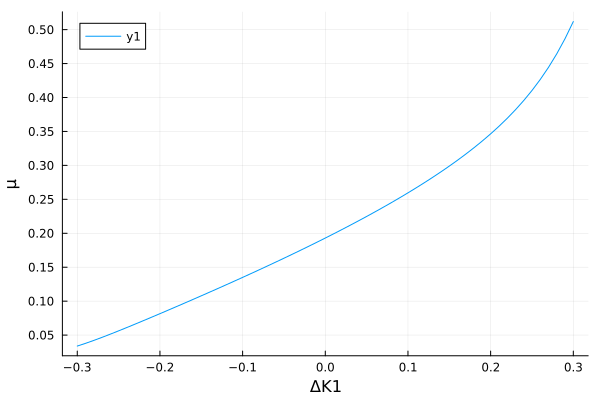

In [74]:
ΔK1_guesses = -0.3:0.01:0.3
plot(ΔK1_guesses, map(t->mu([0,0,0,0,t]), ΔK1_guesses), yticks=0.05:0.05:0.55, xlabel="ΔK1", ylabel="μ")

We see from the plot that $\Delta K_1 \approx 0.09$ seems close to $\mu = 0.25$. After some iterating near there, let's use `0.086778`

In [75]:
mu([0,0,0,0,0.086778])

0.25000025591568364

Let's set the controller to have this `K1` and see how we did:

In [76]:
# Set the quadrupoles:
cq.x = K1 + 0.086778

# Start over bunch:
bunch = Bunch(x=Δx[1], px=Δx[2], y=Δx[3], py=Δx[4])
track!(bunch, bl)

p = Particle(bunch)
M = GTPSA.jacobian(p.v)
acos(1/2*(M[1,1]+M[2,2]))/(2*pi) # About 0.25!

0.2500002673630771

In the general case, we could have nonlinear orbital motion, amplitude dependent tune shifts, and a fully coupled beam. In this case, the trace of the first-order transport matrix is wholly insufficient to quantify the tune. The `NonlinearNormalForm.jl` package should be used instead. Let's check that the `mu` we obtained as a TPSA before is equivalent to that obtained using a proper normal form package.

In [105]:
# Set the quad strengths TPSA back to what we ahd before
cq.x = K1 + ΔK1

# Start over bunch:
bunch = Bunch(x=Δx[1], px=Δx[2], y=Δx[3], py=Δx[4])
track!(bunch, bl)

# Construct a DAMap, using ΔK1 as a parameter
p = Particle(bunch)
m = DAMap(x=[p.v..., ΔK1], nv=4, np=1) # 4 variables, 1 parameter

a = normal(m) # compute the nonlinear normalizing map to transform m into a rotation
c = c_map(m)  # Map to transform into the phasor's basis

# Hide show of very small monomial coefficients
GTPSA.show_eps = 1e-10

# Get the fully nonlinear, amplitude-dependent rotation in phasor's basis
r = inv(c) ∘ inv(a) ∘ m ∘ a ∘ c

# Extract the amplitude dependent tune
mu_NNF = real(log(deriv(r.x[1], 1))/(-2*pi*im))

TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}:
 Coefficient                Order   Exponent
  1.9297099188200589e-01      0      0   0   0   0   0
  6.1298747042403567e-01      1      0   0   0   0   1
  4.0901016168073373e-01      2      0   0   0   0   2
  9.2478622052015302e-01      3      0   0   0   0   3
  2.0489005166551260e+00      4      0   0   0   0   4
  5.3726019692045206e+00      5      0   0   0   0   5
  1.4810554557624910e+01      6      0   0   0   0   6
  4.2928365254905628e+01      7      0   0   0   0   7
  1.2843102743286624e+02      8      0   0   0   0   8
  3.9408568802984871e+02      9      0   0   0   0   9
  1.2330136850087549e+03     10      0   0   0   0  10


Because the orbital motion is fully linear and uncoupled, this should agree completely with our naive trace calculation

In [109]:
mu_NNF - mu # zero!

TPS64{Descriptor(NV=5, VOS=[1, 1, 1, 1, 10], MO=14)}:
 Coefficient                Order   Exponent
  0.0000000000000000e+00      0      0   0   0   0   0
